## This notebook shows how to run a bayesian inference on experimental temperature dependent PL data


The notebook is divided into 4 parts: 

    1. Preparing the data and testing the sampling algorithm;
    
    2. 

### 1. Preparing the data and testing the sampling algorithm;

In [29]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils

#os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 
# access the right directory
os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [30]:
# Process the input data 
# if the data are in xlsx format convert them to csv
import pandas as pd
import glob
from scipy import interpolate
def from_xslx_to_csv(csv_name):
    data = pd.read_excel(csv_name)
    hws = np.arange(0.95, 1.8, 0.01)
    y = np.zeros((hws.size, len(data.values[0,:])))
    y[:,0] = hws
    for i in range(1,len(data.values[0,:])):
        f = interpolate.interp1d(data.values[1:,0], data.values[1:,i], axis=0, fill_value='extrapolate')
        y[:,i] = f(hws)
    data = pd.DataFrame(y, columns=data.columns,index=None)  
    data = data.transpose()
    data = data.rename(columns=data.iloc[0])[1:]
    if data.shape[0]>8:
        data = data.iloc[range(0,data.shape[0],2),:]
    data.to_csv(f'{csv_name.replace(".xlsx",".csv")}')
    return f'{csv_name.replace(".xlsx",".csv")}'
xlsx_files = glob.glob('experiemental_data/2023-12-12-Lowtemp-PL/*.xlsx')
for xlsx_file in xlsx_files:
    csv_name = from_xslx_to_csv(xlsx_file)
    print(csv_name)


experiemental_data/2023-12-12-Lowtemp-PL\GSISO.csv
experiemental_data/2023-12-12-Lowtemp-PL\IDTBR-DIB.csv
experiemental_data/2023-12-12-Lowtemp-PL\IDTBR.csv
experiemental_data/2023-12-12-Lowtemp-PL\IEICO-cn.csv
experiemental_data/2023-12-12-Lowtemp-PL\IEICO.csv
experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F.csv
experiemental_data/2023-12-12-Lowtemp-PL\IT4F-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL\IT4F.csv
experiemental_data/2023-12-12-Lowtemp-PL\ITIC-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL\ITIC.csv
experiemental_data/2023-12-12-Lowtemp-PL\ITIC_no_anneal.csv
experiemental_data/2023-12-12-Lowtemp-PL\L8BO-noanneal.csv
experiemental_data/2023-12-12-Lowtemp-PL\L8BO.csv
experiemental_data/2023-12-12-Lowtemp-PL\PYIT.csv
experiemental_data/2023-12-12-Lowtemp-PL\Y5-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL\Y5.csv
experiemental_data/2023-12-12-Lowtemp-PL\Y6-12mgml-100Canneal.csv
experiemental_data/2023-12-12-Lowte

In [61]:
# Read the experimental data available
import importlib
import glob
csv_files = glob.glob('experiemental_data/2023-12-12-Lowtemp-PL/*.csv')
for id,csv_file in enumerate(csv_files):
    print(id,csv_file)



0 experiemental_data/2023-12-12-Lowtemp-PL\GSISO.csv
1 experiemental_data/2023-12-12-Lowtemp-PL\IDTBR-DIB.csv
2 experiemental_data/2023-12-12-Lowtemp-PL\IDTBR.csv
3 experiemental_data/2023-12-12-Lowtemp-PL\IEICO-cn.csv
4 experiemental_data/2023-12-12-Lowtemp-PL\IEICO.csv
5 experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F-DIO.csv
6 experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F.csv
7 experiemental_data/2023-12-12-Lowtemp-PL\IT4F-DIO.csv
8 experiemental_data/2023-12-12-Lowtemp-PL\IT4F.csv
9 experiemental_data/2023-12-12-Lowtemp-PL\ITIC-DIO.csv
10 experiemental_data/2023-12-12-Lowtemp-PL\ITIC.csv
11 experiemental_data/2023-12-12-Lowtemp-PL\ITIC_no_anneal.csv
12 experiemental_data/2023-12-12-Lowtemp-PL\L8BO-noanneal.csv
13 experiemental_data/2023-12-12-Lowtemp-PL\L8BO.csv
14 experiemental_data/2023-12-12-Lowtemp-PL\PYIT.csv
15 experiemental_data/2023-12-12-Lowtemp-PL\Y5-DIO.csv
16 experiemental_data/2023-12-12-Lowtemp-PL\Y5.csv
17 experiemental_data/2023-12-12-Lowtemp-PL\Y6-12mgml-100Can

experiemental_data/2023-12-12-Lowtemp-PL\Y6-DIB.csv


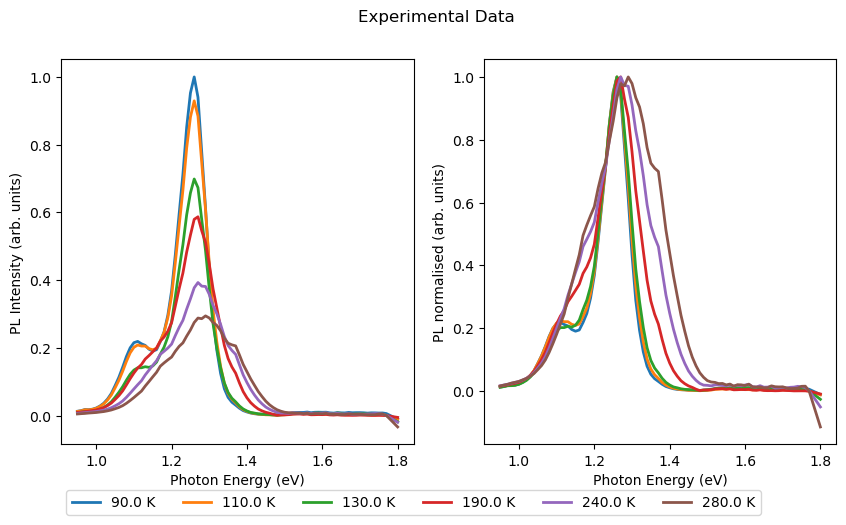

In [62]:
# choose the data to be analysed
# and plot them
csv_name=csv_files[19]
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title="Experimental Data")

In [63]:
# initialise parameters for the model

importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_PL,
    sigma,
) = (5, 10, 0.005, 0.05,0.001)
fixed_parameters_dict = {
    "EX":{},
    "CT":{'off':1},  
    "D":{},
}
params_to_fit_init ={
    "EX":{"E":1.37,"sigma":0.001,"Li":7.8e-2,"Lo":0.11,"hO":0.159},
    "CT":{},
    "D":{},
}
min_bounds = {
    "EX":{"E":1.3,"sigma":0.001,"Li":0.03,"Lo":0.03,"hO":0.1},
    "CT":{},
    "D":{},
}
max_bounds = {
    "EX":{"E":1.5,"sigma":0.03,"Li":0.2,"Lo":0.2,"hO":0.2},
    "CT":{},
    "D":{},
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_PL=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_PL= relative_intensity_std_error_PL,
    temperature_list_PL=temperature_list,
    hws_PL=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood = 5,
    coeff_spread = 0.5,
    nsteps = 10000,
    num_coords = 32,
    database_folder = "fit_experimental_emcee_PL/fit_data_base/",
    data_folder="fit_experimental_emcee_PL/fit_data/",

)

size of hw is (86,)
size of temperature_list is (6,)


In [64]:
importlib.reload(config_utils)
model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
fixed_parameters_dict, params_to_fit, min_bound, max_bound = config_utils.get_dict_params(model_config_save)

model_config['temperature_list_PL'] = temperature_list
model_config['hws_PL'] = hws

save_folder = model_config_save['save_folder']

shape of mean value plot is (86, 6)


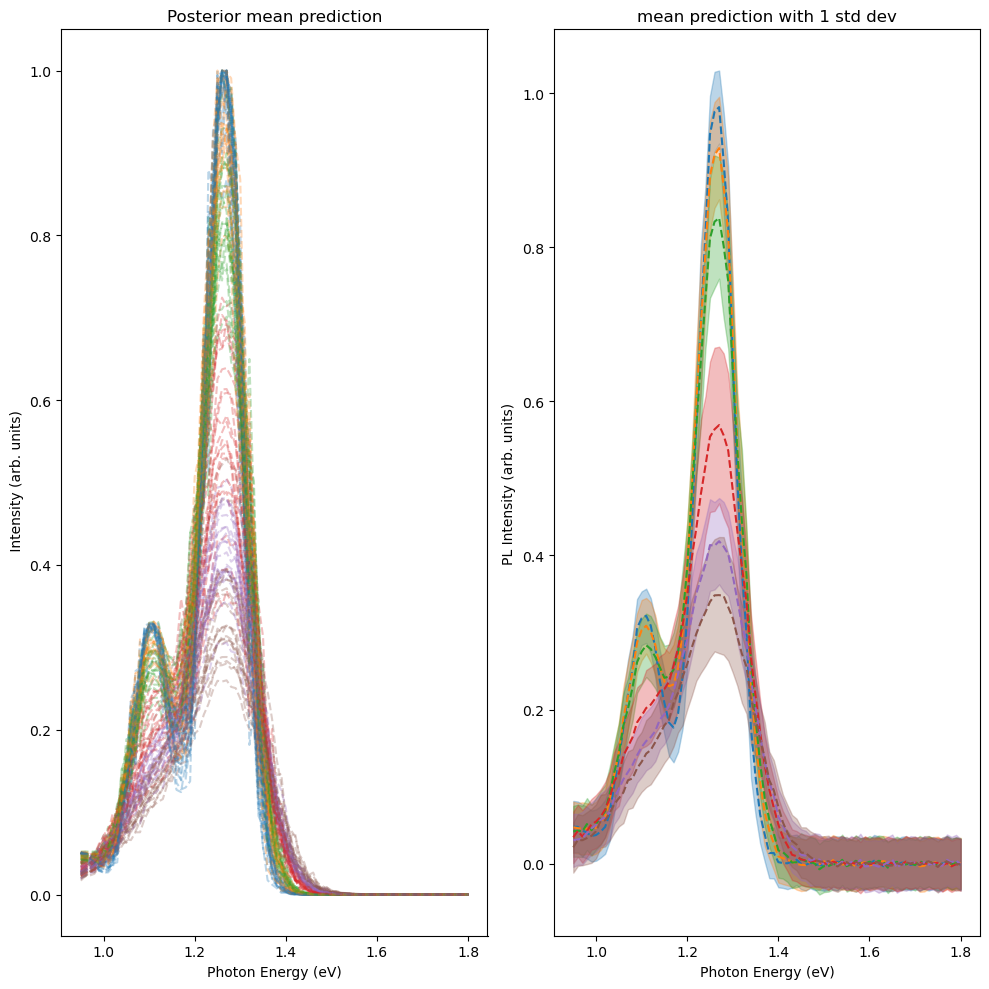

In [65]:
import importlib
importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
# get the variance of the data and plot it

co_var_mat_PL, variance_PL = (
    covariance_utils.plot_generated_data_PL(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=params_to_fit_init,
    )
)

In [66]:
# run a maximum likelihood estimation fit

import importlib
from pl_temp_fit import fit_PL_utils
importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_EL_utils)
importlib.reload(fit_PL_utils)

soln = fit_PL_utils.get_maximum_likelihood_estimate(
    Exp_data,
    co_var_mat_PL,
    model_config,
    save_folder,
    num_coords=1,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit=params_to_fit_init,
    min_bound=min_bounds,
    max_bound=max_bounds,
)

running the minimisation
step 0


(<Figure size 2000x500 with 6 Axes>,
 array([<Axes: title={'center': 'temperature=90.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=110.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=130.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=190.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=240.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=280.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>],
       dtype=object))

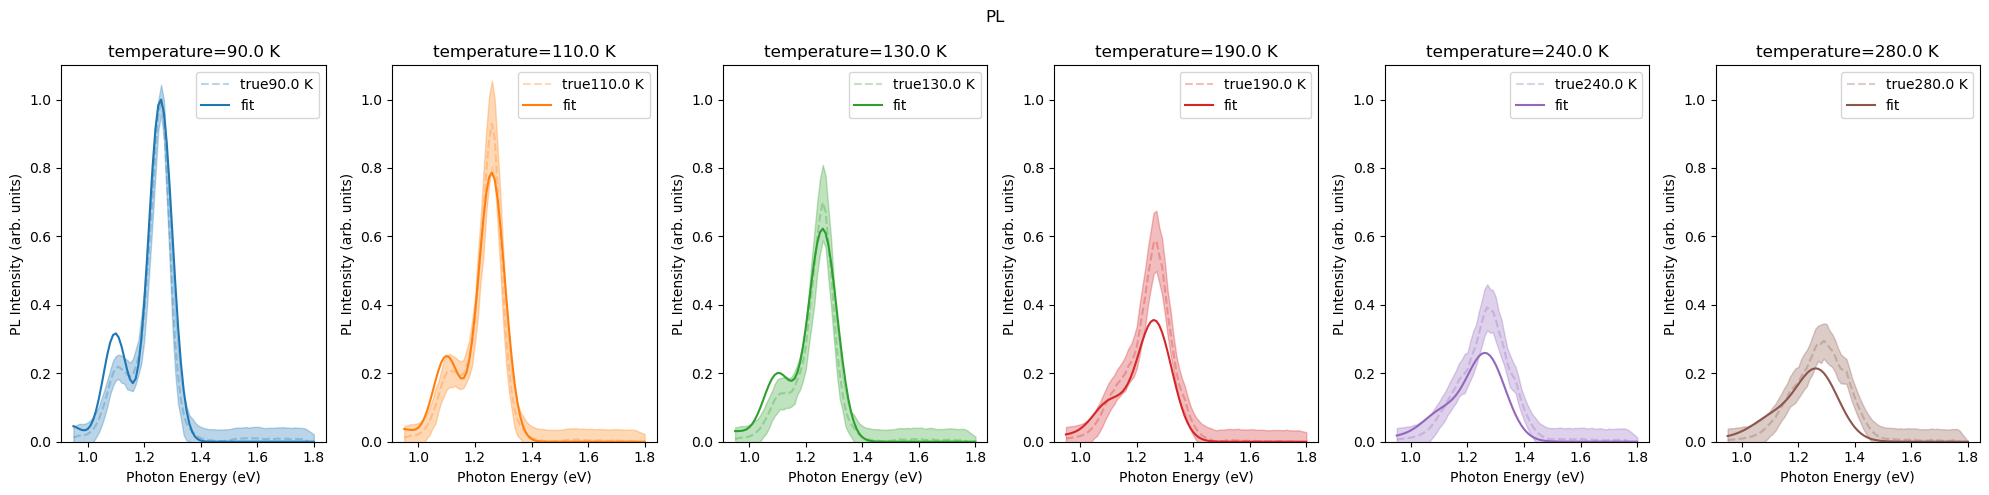

In [ ]:
# plot the results of the maximum likelihood estimation fit

importlib.reload(fit_PL_utils)

true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init,soln.x)
fit_PL_utils.plot_exp_data_with_variance(
    temperature_list,
    hws,
    variance_PL,
    save_folder,
    fixed_parameters_dict,
    true_parameters,
    Exp_data,
)

TypeError: generate_data_PL() missing 2 required positional arguments: 'temperature_list_PL' and 'hws_PL'

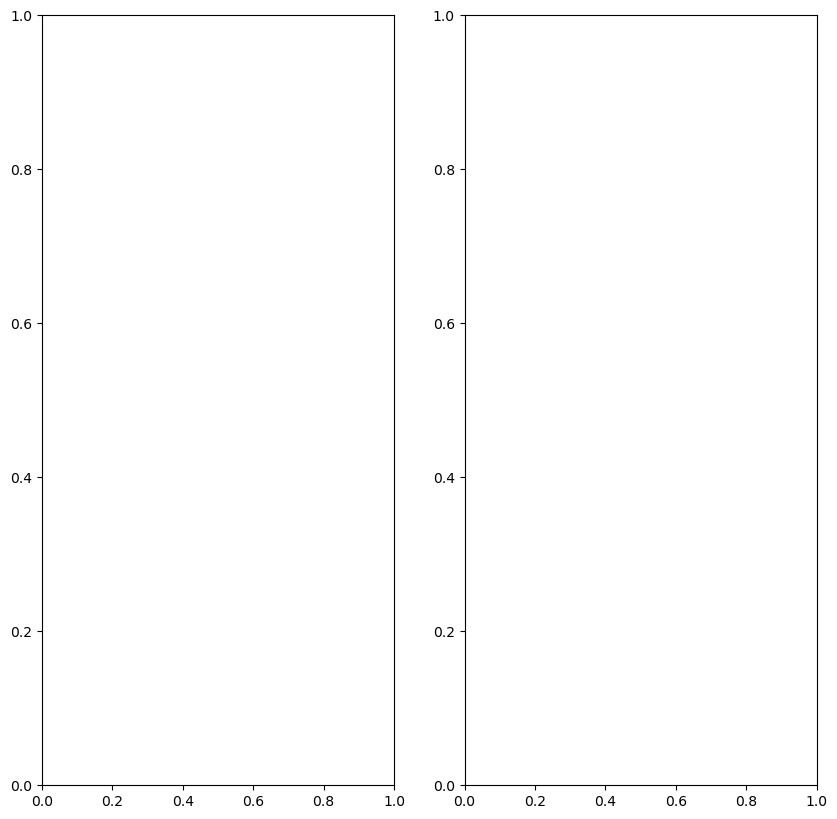

In [ ]:

co_var_mat_PL, variance_PL = (
    covariance_utils.plot_generated_data_PL(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)

In [17]:

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)

fit_PL_utils.run_sampler_single(
    save_folder,
    Exp_data,
    co_var_mat_PL,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=1,
    num_coords = 32,
)


Initial size: 0


You must install the tqdm library to use progress indicators with emcee


single process took 328.5 seconds


In [ ]:

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_PL_utils)

fit_PL_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_PL,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=1,
    num_coords = 32,
    restart_sampling=False
    #num_processes=4,
)


Initial size: 0
num_processes = 12


KeyError: 'temperature_list_PL'

In [59]:
fixed_parameters_dict

{'EX': {}, 'CT': {'off': 1}, 'D': {}}

## submitting jobs to the hpc

In [9]:
# import the data and plot them
import importlib
import glob
csv_files = glob.glob('experiemental_data/2023-12-12-Lowtemp-PL/*.csv')
for id,csv_file in enumerate(csv_files):
    print(id,csv_file)


0 experiemental_data/2023-12-12-Lowtemp-PL\GSISO.csv
1 experiemental_data/2023-12-12-Lowtemp-PL\IDTBR-DIB.csv
2 experiemental_data/2023-12-12-Lowtemp-PL\IDTBR.csv
3 experiemental_data/2023-12-12-Lowtemp-PL\IEICO-cn.csv
4 experiemental_data/2023-12-12-Lowtemp-PL\IEICO.csv
5 experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F-DIO.csv
6 experiemental_data/2023-12-12-Lowtemp-PL\IEICO4F.csv
7 experiemental_data/2023-12-12-Lowtemp-PL\IT4F-DIO.csv
8 experiemental_data/2023-12-12-Lowtemp-PL\IT4F.csv
9 experiemental_data/2023-12-12-Lowtemp-PL\ITIC-DIO.csv
10 experiemental_data/2023-12-12-Lowtemp-PL\ITIC.csv
11 experiemental_data/2023-12-12-Lowtemp-PL\ITIC_no_anneal.csv
12 experiemental_data/2023-12-12-Lowtemp-PL\L8BO-noanneal.csv
13 experiemental_data/2023-12-12-Lowtemp-PL\L8BO.csv
14 experiemental_data/2023-12-12-Lowtemp-PL\PYIT.csv
15 experiemental_data/2023-12-12-Lowtemp-PL\Y5-DIO.csv
16 experiemental_data/2023-12-12-Lowtemp-PL\Y5.csv
17 experiemental_data/2023-12-12-Lowtemp-PL\Y6-12mgml-100Can

experiemental_data/2023-12-12-Lowtemp-PL\Y6-DIB.csv


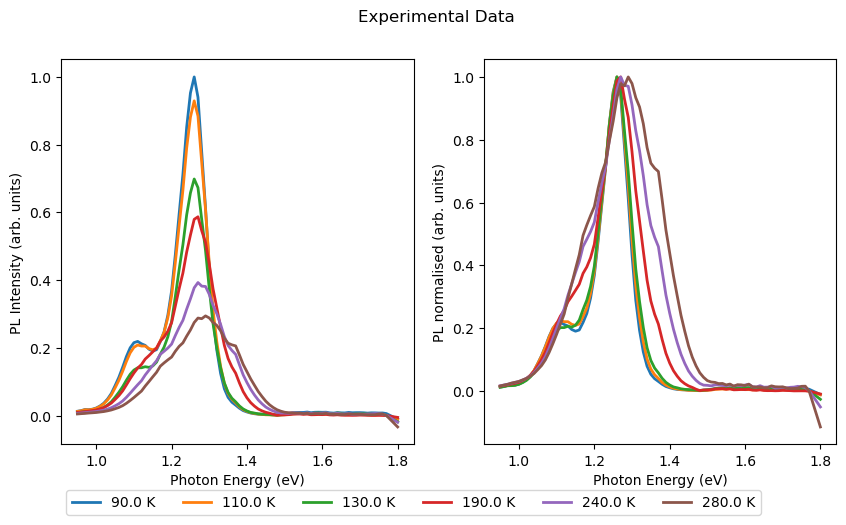

In [3]:
csv_name=csv_files[19]#18,10,14
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title="Experimental Data")

In [18]:
# initialise parameters for the model

importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_PL,
    sigma,
) = (5, 10, 0.005, 0.05,0.001)
fixed_parameters_dict = {
    "EX":{},
    "CT":{'off':1},  
    "D":{},
}
params_to_fit_init ={
    "EX":{"E":1.37,"sigma":0.001,"Li":7.8e-2,"Lo":0.11,"hO":0.159},
    "CT":{},
    "D":{},
}
min_bounds = {
    "EX":{"E":1.3,"sigma":0.001,"Li":0.03,"Lo":0.03,"hO":0.1},
    "CT":{},
    "D":{},
}
max_bounds = {
    "EX":{"E":1.5,"sigma":0.03,"Li":0.2,"Lo":0.2,"hO":0.2},
    "CT":{},
    "D":{}
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_PL=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_PL= relative_intensity_std_error_PL,
    temperature_list_PL=temperature_list,
    hws_PL=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood = 5,
    coeff_spread = 0.5,
    nsteps = 10000,
    num_coords = 32,
    database_folder = "fit_experimental_emcee_PL/fit_data_base/",
    data_folder="fit_experimental_emcee_PL/fit_data/",

)

size of hw is (86,)
size of temperature_list is (8,)


In [52]:
%run src/pl_temp_fit/scripts/run_PL_sampling.py --model_config_id {model_config_id}

running the minimisation
step 0
step 1
step 2
step 3
step 4
[1.44629018 0.02305014 0.07664977 0.10655376 0.15882309]
Maximum likelihood estimates:
  EX_E = 1.446
  EX_sigma = 0.023
  EX_LI = 0.077
  EX_L0 = 0.107
  EX_H0 = 0.159
Maximum log likelihood: 3026.530143441803
Initial size: 0
  6%|▌         | 600/10000 [15:36<4:16:21,  1.64s/it]

  1%|          | 100/10000 [02:40<4:08:37,  1.51s/it]

[10.12154329 11.25736033  9.64151337  9.44401747 10.45381902]


  2%|▏         | 200/10000 [05:13<4:03:09,  1.49s/it]

[14.70162027 16.89767054 19.81710873 18.7216607  17.15815601]


  3%|▎         | 300/10000 [07:50<4:34:01,  1.69s/it]

[18.39101052 20.68532397 25.35204639 25.03679331 20.3241148 ]


  3%|▎         | 342/10000 [08:55<4:00:05,  1.49s/it]

[24.98846733 26.48523432 40.02345272 41.96182638 41.29087558]


  6%|▌         | 601/10000 [15:38<4:16:09,  1.64s/it]

In [38]:

model_config_id = test_id
results_name = csv_name.replace('.csv','').split('/')[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/scripts/run_PL_sampling.py --model_config_id {model_config_id} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  
script= f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"#submit to HPC
!{script}

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


## analyse the results

In [50]:
import glob
from pl_temp_fit import Emcee_utils
json_files = glob.glob('fit_experimental_emcee_PL/fit_data_base/*.json')
list_model_config=[]
for id,json_file in enumerate(json_files):
    try:
        print(id,json_files)
        model_config, model_config_save = config_utils.load_model_config(json_file.split('/')[-1].replace('.json',''), database_folder = "fit_experimental_emcee_PL")
    except Exception as e:
        print(e)
        #if os.path.exists(json_file):
        #    os.remove(json_file)
        continue
    if os.path.exists(model_config_save['save_folder']+'/sampler.h5'):
        print(id,json_file)
        
        filename = model_config_save['save_folder'] + "/sampler.h5"
        try: 
            reader = Emcee_utils.hDFBackend_2(filename, name="multi_core")
            distribution = reader.get_chain(flat=True)
        except:
            reader = Emcee_utils.hDFBackend_2(filename, name="single_core")
            distribution = reader.get_chain(flat=True)
        
        true_parameters=list(np.mean(distribution,axis=0))
        model_config_save['mean'] = [f"{x:.3f}" for x in true_parameters]          
        model_config_save['num_iteration'] = reader.iteration  
        log_prob = reader.get_log_prob( flat=True)  
        model_config_save['max_log_prob'] = np.max(log_prob)
        list_model_config.append(model_config_save)
    #else:
            #os.remove(json_file)
           # for file in glob.glob(model_config_save['save_folder']+'/*'):
            #    os.remove(file)
            #os.rmdir(model_config_save['save_folder'])

    

0 ['fit_experimental_emcee_PL/fit_data_base\\2aa44759-8f8b-4dc9-a47d-2531ca2764e7.json', 'fit_experimental_emcee_PL/fit_data_base\\43fd566a-024e-4648-8073-568274c8da7a.json']
0 fit_experimental_emcee_PL/fit_data_base\2aa44759-8f8b-4dc9-a47d-2531ca2764e7.json
1 ['fit_experimental_emcee_PL/fit_data_base\\2aa44759-8f8b-4dc9-a47d-2531ca2764e7.json', 'fit_experimental_emcee_PL/fit_data_base\\43fd566a-024e-4648-8073-568274c8da7a.json']
1 fit_experimental_emcee_PL/fit_data_base\43fd566a-024e-4648-8073-568274c8da7a.json


In [51]:
import pandas as pd
df_all = pd.DataFrame(list_model_config)
df_all

,Temp_std_err,hws_std_err,relative_intensity_std_error_PL,relative_intensity_std_error_EL,sigma,save_folder,csv_name_PL,csv_name_EL,date,test_id,...,params_to_fit_init,min_bounds,max_bounds,num_iteration_max_likelihood,coeff_spread,nsteps,num_coords,mean,num_iteration,max_log_prob
0,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_06_04...,experiemental_data/2023-12-12-Lowtemp-PL\Y6-DI...,,2024_06_04,2aa44759-8f8b-4dc9-a47d-2531ca2764e7,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'Li': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.371, 0.002, 0.073, 0.110, 0.159]",52,-191.071717
1,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_05_17...,experiemental_data/2023-12-12-Lowtemp-PL\Y6-DI...,,2024_05_17,43fd566a-024e-4648-8073-568274c8da7a,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'Li': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.366, 0.001, 0.080, 0.111, 0.156]",5,-203.693687


## plots

Initial size: 5
(96,)


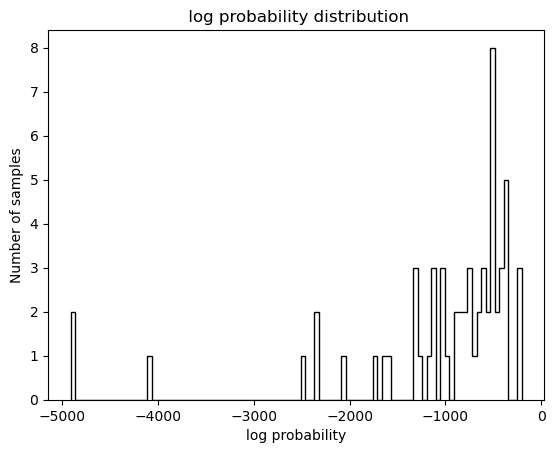

C:\Users\ma11115\AppData\Local\Temp\ipykernel_19104\1871100770.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\cond\envs\pymc_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\cond\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(96,)


C:\Users\ma11115\AppData\Local\Temp\ipykernel_19104\1871100770.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


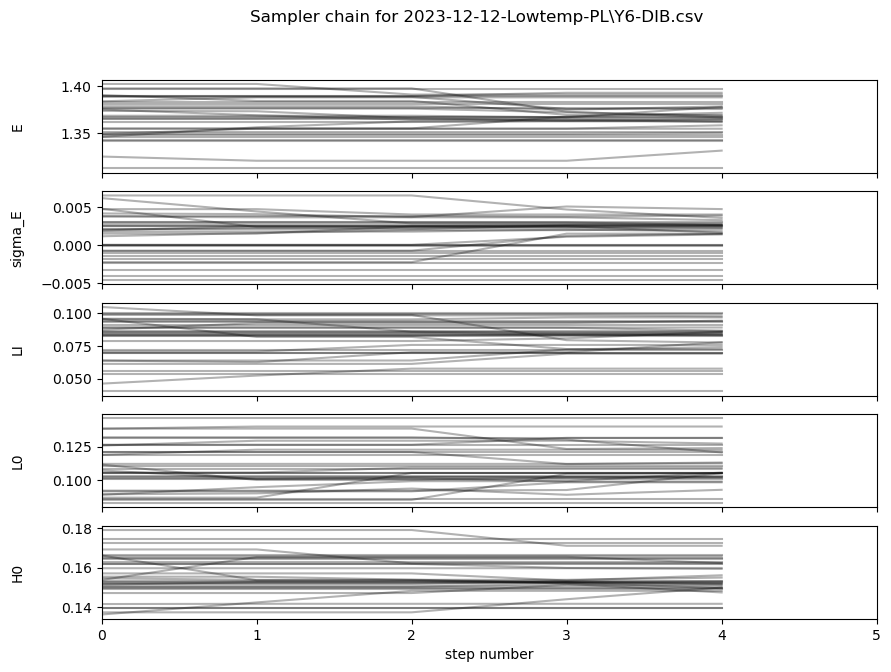

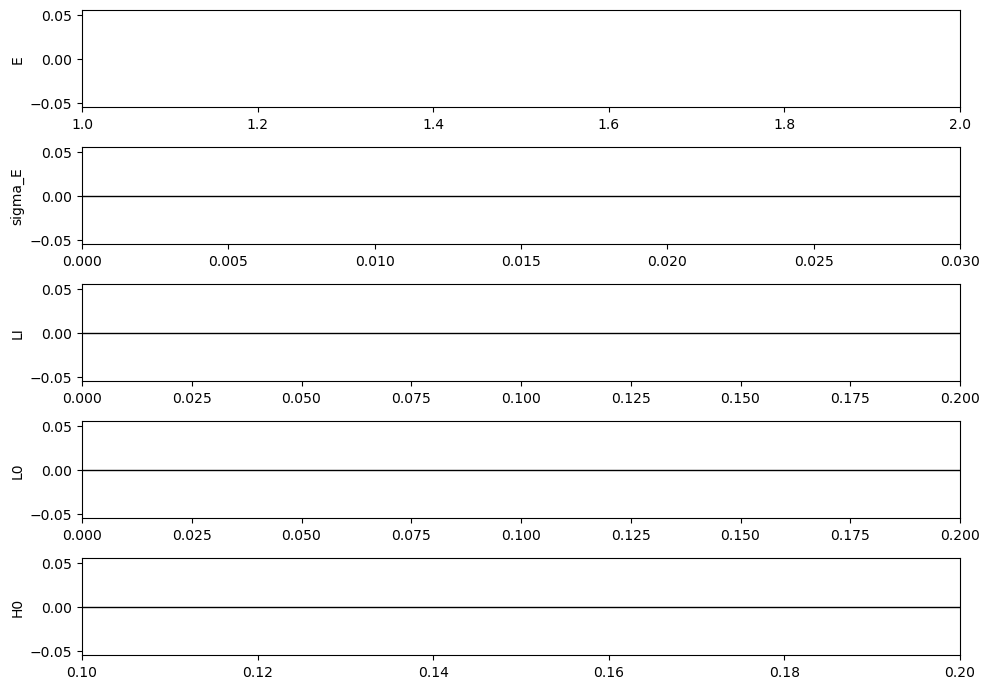

In [18]:
# reload sampler from file
index = 0
filename = df_all['save_folder'][index] + "/sampler.h5"
csv_name = df_all['csv_name_PL'][index]
model_config, model_config_save = config_utils.load_model_config(df_all['test_id'][index], database_folder = "fit_experimental_emcee_PL/fit_data_base/")
try: 
    reader = Emcee_utils.hDFBackend_2(filename, name="multi_core")
    distribution = reader.get_chain(flat=True)
except:
    reader = Emcee_utils.hDFBackend_2(filename, name="single_core")
    distribution = reader.get_chain(flat=True)
print("Initial size: {0}".format(reader.iteration))
#load data and plot the relevant histograms
flat_samples = reader.get_log_prob(discard=2, thin=1, flat=True)
print(flat_samples.shape)
plt.hist(flat_samples[flat_samples>-1e4], 100, color="k", histtype="step")
plt.xlabel("log probability")
plt.ylabel("Number of samples")
#plt.xlim(-100,0)
plt.title(' log probability distribution')
plt.show()
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = reader.get_chain()
labels = ["E", "sigma_E", "LI", "L0", "H0"]
ndim = len(labels)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
fig.show()
#flat_samples.shape
distribution = reader.get_chain(discard=100, thin=5, flat=True)
true_parameters=list(np.mean(distribution,axis=0))
print(flat_samples.shape)
fig, axes = plt.subplots(5, figsize=(10, 7))
axes_xlim = [[1,2],[0,0.03],[0,0.2],[0,0.2],[0.1,0.2]]
for i in range(ndim):
    ax = axes[i]
    ax.hist(distribution[:, i], 200, color="k", histtype="step")
    ax.set_ylabel(labels[i])
    ax.set_xlim(axes_xlim[i])
fig.tight_layout()
fig.show()


experiemental_data/2023-12-12-Lowtemp-PL\Y6-DIB.csv
 true parameter mean [nan, nan, nan, nan, nan]
shape of mean value plot is (86, 6)


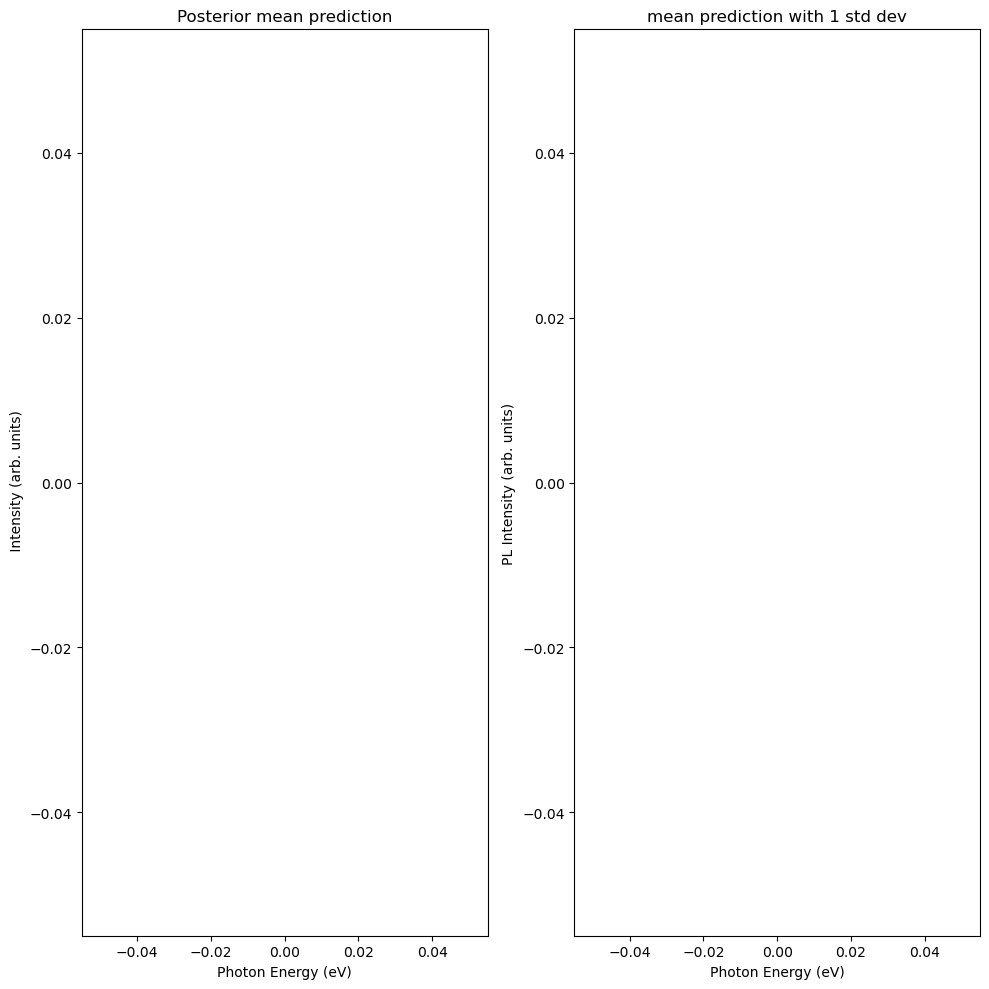

In [19]:

from pl_temp_fit import fit_PL_utils
print(csv_name)
fixed_parameters_dict, params_to_fit_init, min_bounds, max_bounds = (
        config_utils.get_dict_params(model_config_save)
    )
save_folder = model_config_save['save_folder']
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
true_parameters=list(np.mean(distribution,axis=0))
print(' true parameter mean' ,true_parameters)
model_config['temperature_list_PL'] = temperature_list
model_config['hws_PL'] = hws

true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init, true_parameters)
co_var_mat_PL, variance_PL = (
    covariance_utils.plot_generated_data_PL(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters
    )
)



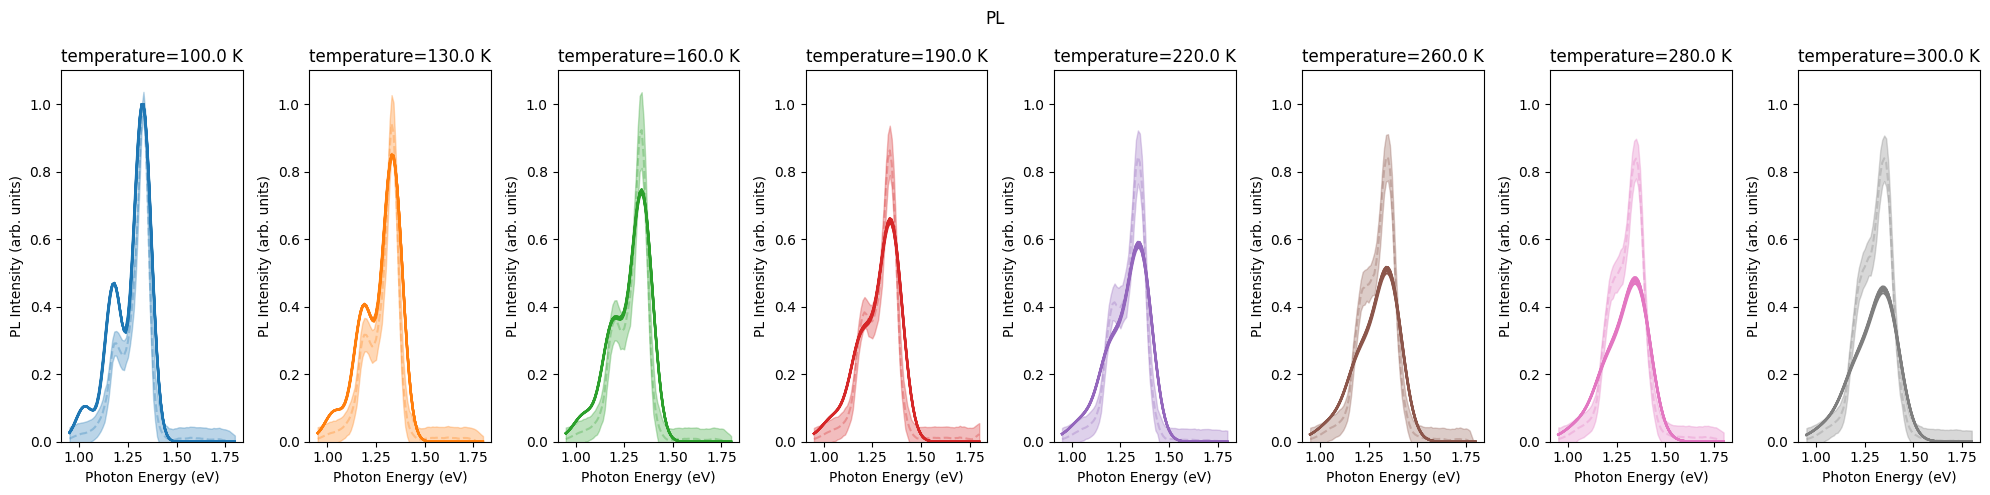

In [24]:
import importlib
importlib.reload(fit_PL_utils)

samples = reader.get_chain(discard=200, thin=15, flat=True)
fig, ax = fit_PL_utils.plot_exp_data_with_variance(
        temperature_list,
        hws,
        variance_PL,
        save_folder,
        fixed_parameters_dict,
        true_parameters,
        Exp_data,
    )
for true_parameters in distribution[np.random.choice(len(distribution),10),:]:

    true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init, true_parameters)

    fig,ax = fit_PL_utils.plot_exp_data_with_variance(
        temperature_list,
        hws,
        variance_PL,
        save_folder,
        fixed_parameters_dict,
        true_parameters,
        Exp_data,
        fig=fig,
        axis=ax
    )

# delete legend from ax
for axis in ax:
    axis.get_legend().remove()

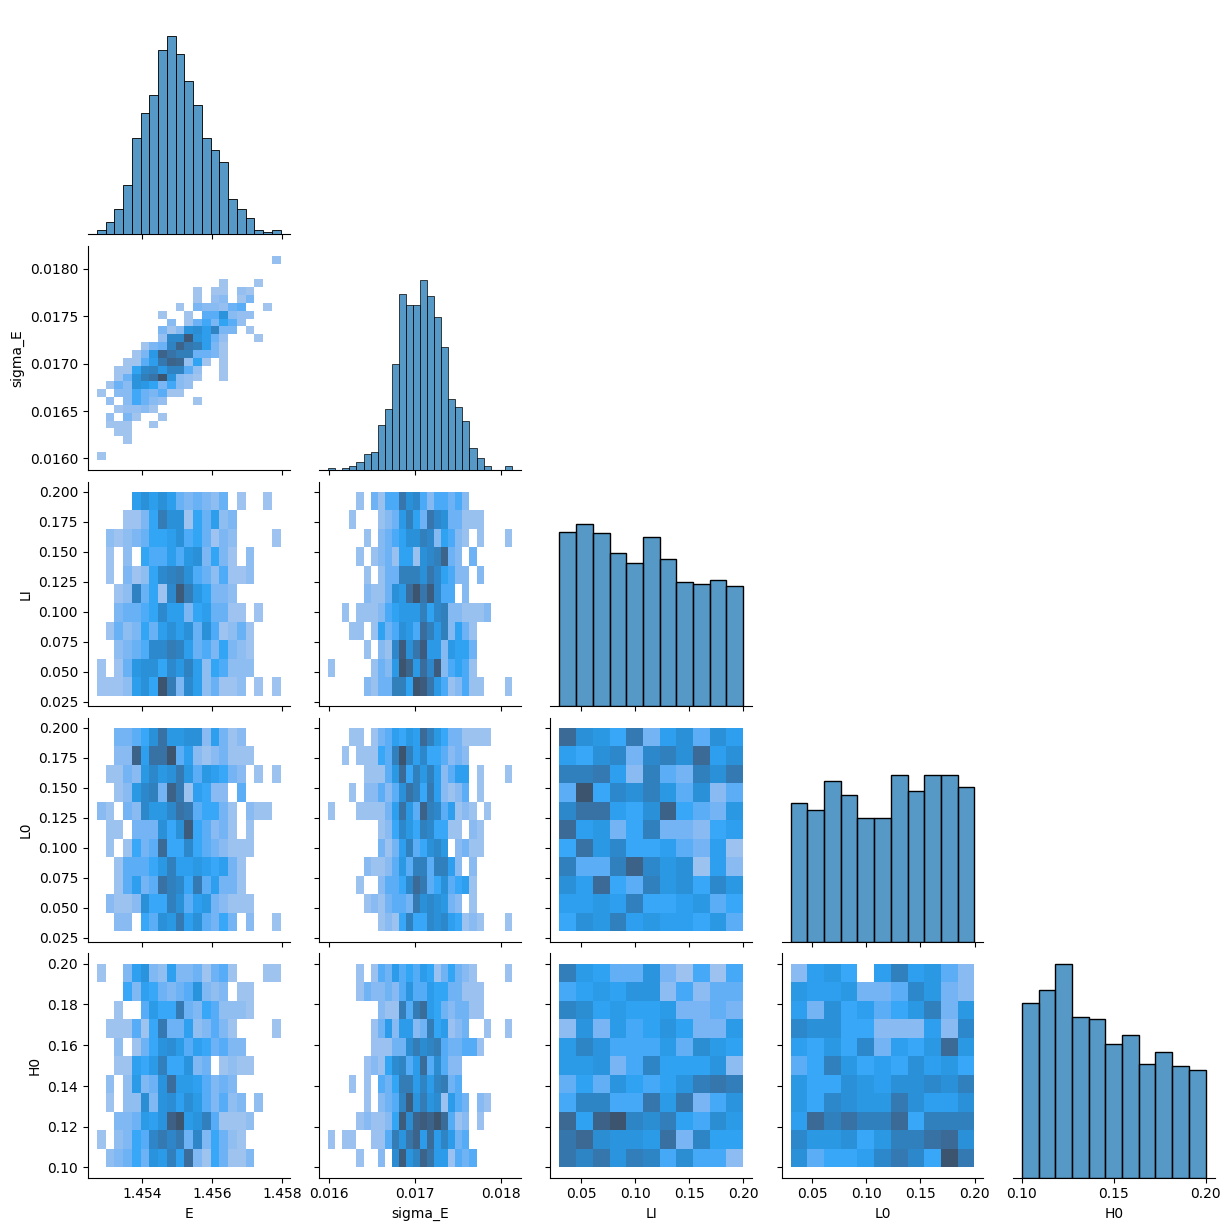

In [12]:
import seaborn as sns
samples = reader.get_chain(discard=200, thin=15, flat=True)
df_samples = pd.DataFrame(samples, columns=labels)
g = sns.pairplot(df_samples, kind="hist", corner=True)